In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# from scipy.stats import beta
# import plotly.express as px
# from datetime import datetime
# from dotenv import load_dotenv
# from snowflake import connector

# from numpy import asarray
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.metrics import mean_squared_error, r2_score, make_scorer
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
# from functools import partial

# import warnings
# # Filter out all warnings
# warnings.filterwarnings('ignore', category=Warning)

from leading_indicator_v2 import *

load_dotenv('/Users/peter/.env')

# establish Snowflake connection
connection = connector.connect(user=os.getenv("SNOWFLAKE_USERNAME"), 
                  password=os.getenv("SNOWFLAKE_PASSWORD"), 
                  account=os.getenv("SNOWFLAKE_ACCOUNT"), 
                  role=os.getenv("SNOWFLAKE_ROLE"), 
                  warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
                  database = 'DISCO_CORE' 
                  )

## Prepare Data

In [2]:
df = ingest_clean_data(connection)
df.tail(5)

Ingesting performance data from 2024-04-01
Data successfully ingested.


,event_date,bert_boost_classic_brand_displays,contextual_classic_brand_displays,nurture_brand_displays,other_brand_displays,waterfall_brand_displays,bert_boost_classic_zeroday_ad_spend,contextual_classic_zeroday_ad_spend,nurture_zeroday_ad_spend,other_zeroday_ad_spend,waterfall_zeroday_ad_spend,order_count,final_conv_count,final_ad_spend,rpl,day_of_week,day_of_month,rpl_index
60,2024-05-31,209955.0,19444.0,13773.0,28683.0,82215.0,783.98,43.00,125.0,50.0,385.50,142423,320,5198.27,0.019,4,31,0.701132
61,2024-06-01,145486.0,16631.0,13853.0,18342.0,62918.0,696.10,71.00,155.0,160.1,280.00,180592,235,3531.10,0.018,5,1,0.912064
62,2024-06-02,163457.0,20346.0,16052.0,20440.0,75562.0,1121.10,31.50,135.0,65.0,256.00,169012,187,2994.10,0.014,6,2,1.106863
63,2024-06-03,226498.0,20236.0,14735.0,28985.0,87196.0,1738.07,77.72,113.0,45.0,106.00,183859,216,3338.79,0.011,0,3,1.340846
64,2024-06-04,220326.0,22676.0,14688.0,38583.0,94892.0,1328.00,25.00,70.0,163.0,285.42,172800,158,2283.92,0.008,1,4,1.327796


## Modeling

In [4]:
scaled_df = scale_data(df)
unattributed_days, attributed_days = remove_last_n_days(scaled_df, 14)

Total Days: (65, 18)
Unattributed Days: (14, 18)
Attributed Days: (51, 18)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


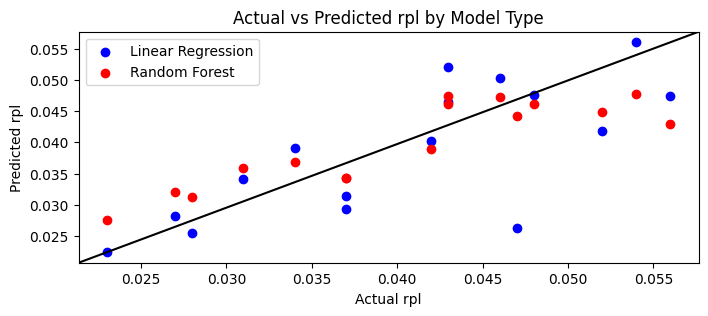

,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,Linear Regression,0.007335,0.002301,0.127,0.045
1,Random Forest,0.005121,0.001451,0.110,0.032


In [5]:
results, linear_reg, best_rf_model = find_model_performance(attributed_days, objective = 'rpl', random_sample=True, training_size= 0.7)
results

In [9]:
results, xgb_model = train_xg_model(attributed_days, training_size = 0.7, validation_size = 0.05, objective = 'rpl', random_sample=True)
results

[0]	train-rmse:0.44807	valid-rmse:0.45548


[200]	train-rmse:0.00531	valid-rmse:0.00728
[266]	train-rmse:0.00152	valid-rmse:0.00735


,model,RMSE Test,RMSE Train,Mean Abs Error % Test,Mean Abs Error % Train
0,XGBoost_initial,0.005293,0.001524,-0.028,-0.019


## Predict

In [10]:
def predict_unattributed_days(unattributed_days, lr_model, rf_model, xgb_model, objective = 'rpl'):
    X_unattributed = unattributed_days.copy()
    X_unattributed.drop(columns=['event_date', 'final_conv_count', 'final_ad_spend', 'rpl'], inplace=True)
    y_unattributed = unattributed_days[objective]
    current_date = datetime.today().date()

    #Setup prediction output df 
    prediction_df = unattributed_days[['event_date']]
    prediction_df['model_date'] = current_date
    prediction_df['model_date'] = pd.to_datetime(prediction_df['model_date'])

    #Predict RPM for each model
    prediction_df['rpm_lr'] = lr_model.predict(X_unattributed).round(4)
    prediction_df['rpm_rf'] = rf_model.predict(X_unattributed).round(4)
    prediction_df['rpm_xgb'] = xgb_model.predict(X_unattributed).round(4)


    prediction_df.to_csv(f'data/output/prediction_df_{current_date}.csv', index=False)
    return prediction_df

In [27]:
#Split unattributed_days into X and y


prediction_df = unattributed_days[['event_date']]
prediction_df['model_date'] = datetime.today().date()
#convert the model_date column to datetime
prediction_df['model_date'] = pd.to_datetime(prediction_df['model_date'])

#Predict the rpl using both models and add the results to the prediction_df
prediction_df['rpm_lr'] = linear_reg.predict(X_unattributed).round(4)
prediction_df['rpm_rf'] = best_rf_model.predict(X_unattributed).round(4)
prediction_df['rpm_xg'] = xgb_model.predict(xgb.DMatrix(X_unattributed)).round(4)

current_date = datetime.today().date()
# prediction_df.to_csv(f'data/output/prediction_df_{current_date}.csv', index=False)
prediction_df

,event_date,model_date,rpm_lr,rpm_rf,rpm_xg
51,2024-05-22,2024-06-05,0.0467,0.0456,0.0358
52,2024-05-23,2024-06-05,0.0541,0.0481,0.0444
53,2024-05-24,2024-06-05,0.0579,0.0482,0.0454
54,2024-05-25,2024-06-05,0.0603,0.0481,0.0426
55,2024-05-26,2024-06-05,0.0570,0.0485,0.0442
56,2024-05-27,2024-06-05,0.0593,0.0440,0.0441
57,2024-05-28,2024-06-05,0.0560,0.0409,0.0413
58,2024-05-29,2024-06-05,0.0483,0.0444,0.0446
59,2024-05-30,2024-06-05,0.0492,0.0457,0.0415
60,2024-05-31,2024-06-05,0.0501,0.0450,0.0386


## Write Output

In [23]:
from snowflake.connector.pandas_tools import write_pandas
from snowflake.connector.pandas_tools import pd_writer
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

# Establish Snowflake connection with the schema specified
connection = connector.connect(
    user=os.getenv("SNOWFLAKE_USERNAME"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    role=os.getenv("SNOWFLAKE_ROLE"),
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database='DISCO_CORE',
    schema='PLAYGROUND_ANALYTICS'  # Set the schema here
)

(True,
 1,
 14,
 [('odaguzuqwq/file0.txt', 'LOADED', 14, 14, 1, 0, None, None, None, None)])

In [30]:
output_table = 'leading_indicator_predictions_fingerprinting'
#upper case all of the column names of the prediction_df
prediction_df.columns = [col.upper() for col in prediction_df.columns]
# First, ensure the table exists with the correct schema
# create_table_query = f"""
# CREATE OR REPLACE TABLE PLAYGROUND_ANALYTICS.LEADING_INDICATOR_PREDICTIONS_FINGERPRINTING (
#     EVENT_DATE DATE,
#     MODEL_DATE DATE,
#     RPM_LR FLOAT,
#     RPM_RF FLOAT,
#     RPM_XG FLOAT
# );
# """

# # Execute the create table query
# cursor = connection.cursor()
# cursor.execute(create_table_query)
# cursor.close()

prediction_df['EVENT_DATE'] = pd.to_datetime(prediction_df['EVENT_DATE']).dt.date
prediction_df['MODEL_DATE'] = pd.to_datetime(prediction_df['MODEL_DATE']).dt.date

# Optionally convert to string if required by your specific setup
prediction_df['EVENT_DATE'] = prediction_df['EVENT_DATE'].astype(str)
prediction_df['MODEL_DATE'] = prediction_df['MODEL_DATE'].astype(str)

# Now, write the DataFrame to the table
write_pandas(
    conn=connection,
    df=prediction_df,
    table_name='LEADING_INDICATOR_PREDICTIONS_FINGERPRINTING',
    auto_create_table=False  # Now we don't need to auto-create since it's explicitly created
)

(True,
 1,
 14,
 [('flzpsidola/file0.txt', 'LOADED', 14, 14, 1, 0, None, None, None, None)])